## CP02 - Regressão Logistica | Reconhecimento de Gênero por voz
### Prova - Regressão Logística
---

In [1]:
# Passo 0: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
RND = 42

## Carregar e visualizar o dataset

In [2]:
url = 'https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


### Explicação dos Features do Dataset

- **meanfreq**: Média da frequência fundamental (pitch) do áudio.
- **sd**: Desvio padrão da frequência fundamental.
- **median**: Mediana da frequência fundamental.
- **Q25**: Primeiro quartil (25%) da frequência fundamental.
- **Q75**: Terceiro quartil (75%) da frequência fundamental.
- **IQR**: Intervalo interquartil (Q75 - Q25) da frequência fundamental.
- **skew**: Assimetria da distribuição das frequências.
- **kurt**: Curtose da distribuição das frequências.
- **sp.ent**: Entropia espectral, mede a desordem do espectro.
- **sfm**: Medida de planicidade espectral (Spectral Flatness Measure).
- **mode**: Valor mais frequente da frequência fundamental.
- **centroid**: Centroide espectral, indica o "centro de massa" do espectro.
- **meanfun**: Média da frequência fundamental ao longo do tempo.
- **minfun**: Valor mínimo da frequência fundamental.
- **maxfun**: Valor máximo da frequência fundamental.
- **meandom**: Média do domínio de frequência.
- **mindom**: Valor mínimo do domínio de frequência.
- **maxdom**: Valor máximo do domínio de frequência.
- **dfrange**: Amplitude do domínio de frequência (maxdom - mindom).
- **modindx**: Índice de modulação, mede a variação da frequência fundamental.
- **label**: Classe alvo, indica o gênero da voz (`male` ou `female`).

In [ ]:
df['label'].value_counts(normalize=True), df.describe().T

(label
 male      0.5
 female    0.5
 Name: proportion, dtype: float64,
            count       mean         std       min       25%       50%  \
 meanfreq  3168.0   0.180907    0.029918  0.039363  0.163662  0.184838   
 sd        3168.0   0.057126    0.016652  0.018363  0.041954  0.059155   
 median    3168.0   0.185621    0.036360  0.010975  0.169593  0.190032   
 Q25       3168.0   0.140456    0.048680  0.000229  0.111087  0.140286   
 Q75       3168.0   0.224765    0.023639  0.042946  0.208747  0.225684   
 IQR       3168.0   0.084309    0.042783  0.014558  0.042560  0.094280   
 skew      3168.0   3.140168    4.240529  0.141735  1.649569  2.197101   
 kurt      3168.0  36.568461  134.928661  2.068455  5.669547  8.318463   
 sp.ent    3168.0   0.895127    0.044980  0.738651  0.861811  0.901767   
 sfm       3168.0   0.408216    0.177521  0.036876  0.258041  0.396335   
 mode      3168.0   0.165282    0.077203  0.000000  0.118016  0.186599   
 centroid  3168.0   0.180907    0.029918

### Escalas das Features e Padronização

No dataset de reconhecimento de gênero por voz, as features apresentam escalas muito distintas. Por exemplo, variáveis como `skew` e `kurt` podem atingir valores na casa das centenas ou milhares, enquanto outras, como `meandom`, `mindom` e `modindx`, possuem valores próximos de zero. Essa diferença de magnitude pode causar problemas em algoritmos que dependem de distância ou gradiente, como a regressão logística.

A padronização (normalização) das features é fundamental para:

- **Evitar que variáveis de maior escala dominem o processo de aprendizado**, tornando o modelo mais justo e eficiente.
- **Acelerar a convergência dos algoritmos de otimização**, pois gradientes ficam mais equilibrados.
- **Melhorar a performance de modelos sensíveis à escala**, como SVM, KNN e regressão logística.

Portanto, padronizar as features garante que todas contribuam de forma equivalente para o modelo, resultando em um aprendizado mais estável e previsões mais confiáveis.

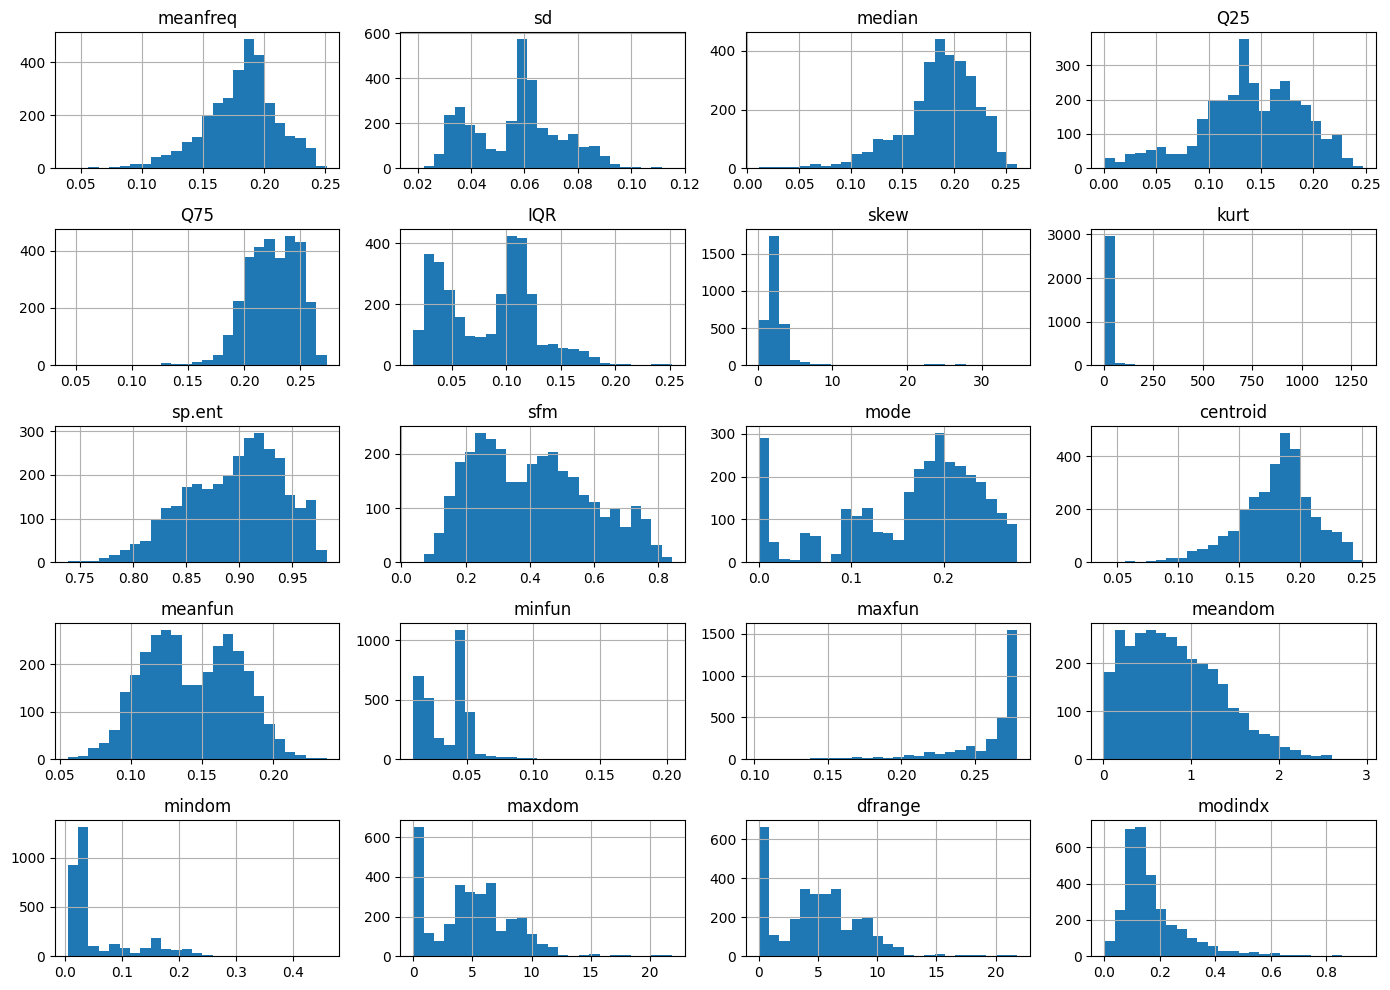

In [4]:
df.hist(bins=25, figsize=(14,10))
plt.tight_layout()
plt.show()

## Matriz de correlação e multicolinearidade
-- mostra a corelação dos features ente si

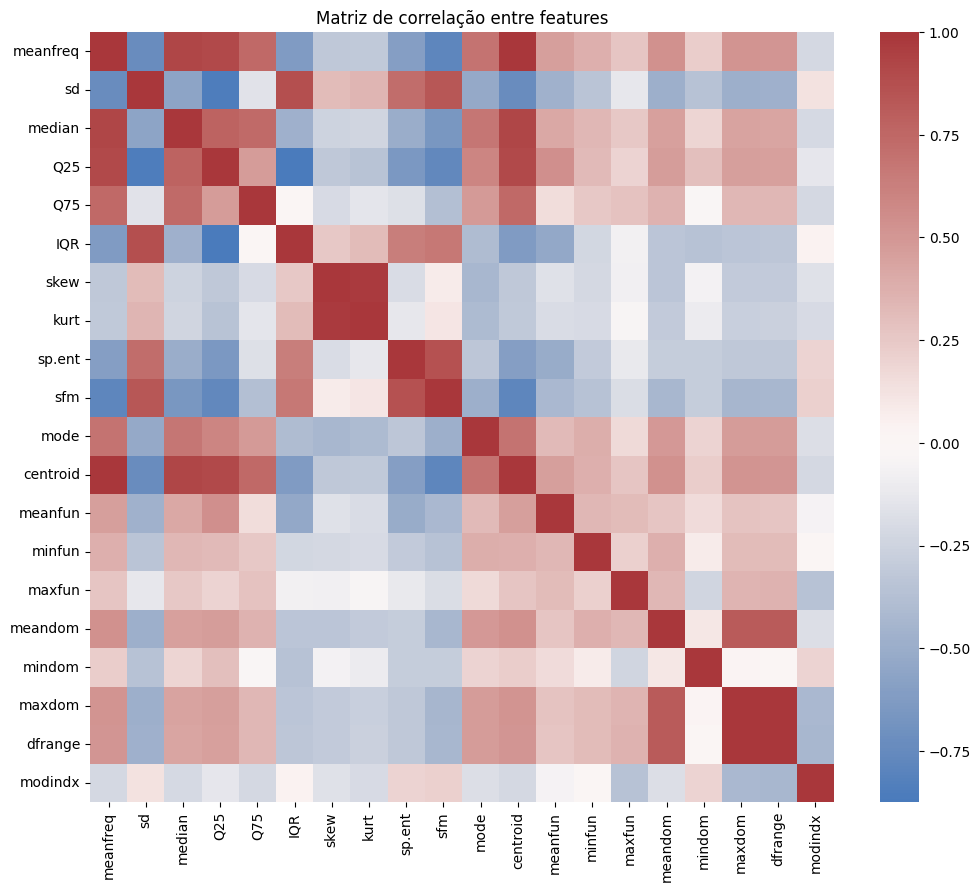

In [ ]:

X_df = df.drop(columns=['label'])
corr = X_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='vlag', center=0)
plt.title('Matriz de correlação entre features')
plt.show()

### Seleção de Features para Melhorar o Modelo

- **Altíssima correlação:** Features altamente correlacionadas entre si podem ser removidas para evitar multicolinearidade. Por exemplo:
    - `meanfreq`, `centroid` e `median` possuem correlação > 0.9. Pode-se manter apenas uma delas.
    - `maxdom` e `dfrange` têm correlação quase perfeita (≈1). Manter apenas uma.
- **Redundância:** Features como `Q25`, `Q75` e `IQR` são relacionadas; pode-se manter só uma ou duas.
- **Baixa relevância:** Features com baixa correlação com o alvo ou baixa variabilidade podem ser descartadas após análise de importância.
- **Exemplo prático:** 
    - Remover: `centroid`, `dfrange`, `Q25`, `maxdom`
    - Manter: `meanfreq`, `IQR`, `median`, `modindx`, etc.

> Recomenda-se usar métodos automáticos (ex: análise de importância dos coeficientes, Recursive Feature Elimination) para validar a escolha.

### Preparação dos dados

In [12]:
X = X_df.values
y = (df['label'] == 'male').astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RND, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## GridSearchCV com L1 e L2

In [14]:
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(solver='saga', max_iter=5000, random_state=RND)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
grid = GridSearchCV(lr, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_s, y_train)
print('Melhor Score (CV):', grid.best_score_)
print('Melhores Parâmetros:', grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor Score (CV): 0.9713808049535604
Melhores Parâmetros: {'C': 1, 'penalty': 'l2'}


In [15]:
from sklearn.feature_selection import RFE

# Usar o melhor modelo de regressão logística encontrado pelo GridSearchCV
estimator = LogisticRegression(
    penalty=grid.best_params_['penalty'],
    C=grid.best_params_['C'],
    solver='saga',
    max_iter=5000,
    random_state=RND
)
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_train_s, y_train)

# Features selecionadas
selected_features = X_df.columns[rfe.support_]
print("Features selecionadas:", list(selected_features))

# Novo dataframe apenas com as features selecionadas
X_df_sel = X_df[selected_features]

Features selecionadas: ['Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'meanfun', 'minfun', 'modindx']


## Avaliação do modelo final

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       396
           1       0.97      0.98      0.97       396

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792



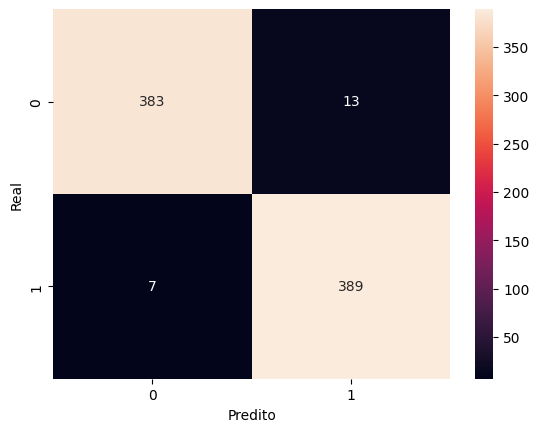

In [16]:
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test_s)
y_proba = best_lr.predict_proba(X_test_s)[:,1]
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

O bloco acima realiza a avaliação do modelo de regressão logística treinado com os melhores hiperparâmetros encontrados pelo GridSearchCV:

- Utiliza o modelo `best_lr` para prever os rótulos (`y_pred`) e probabilidades (`y_proba`) no conjunto de teste.
- Exibe o relatório de classificação (`classification_report`), mostrando métricas como acurácia, precisão, recall e F1-score.
- Calcula e plota a matriz de confusão, permitindo visualizar os acertos e erros do modelo na classificação dos gêneros de voz.
- O heatmap facilita a interpretação dos resultados, destacando onde o modelo mais erra ou acerta.

## Comparação de coeficientes L1 vs L2

In [17]:
lr_l1 = LogisticRegression(penalty='l1', solver='saga', C=grid.best_params_['C'], max_iter=5000, random_state=RND)
lr_l2 = LogisticRegression(penalty='l2', solver='saga', C=grid.best_params_['C'], max_iter=5000, random_state=RND)
lr_l1.fit(X_train_s, y_train)
lr_l2.fit(X_train_s, y_train)
df_coef = pd.DataFrame({
    'feature': X_df.columns,
    'coef_L1': lr_l1.coef_.flatten(),
    'coef_L2': lr_l2.coef_.flatten()
})
df_coef['zerado_L1'] = df_coef['coef_L1'] == 0
df_coef.sort_values('coef_L2', ascending=False).head(10)

,feature,coef_L1,coef_L2,zerado_L1
8,sp.ent,1.398296,1.282734,False
5,IQR,2.284167,1.266195,False
4,Q75,0.088514,0.701636,False
13,minfun,0.541483,0.521573,False
15,meandom,0.170645,0.185888,False
10,mode,0.096137,0.137424,False
1,sd,0.000000,0.135064,True
2,median,0.000000,0.031022,True
18,dfrange,0.000004,-0.001421,False
17,maxdom,0.000003,-0.003273,False


O bloco acima implementa a comparação dos coeficientes dos modelos de regressão logística com penalização L1 e L2:

- Treina dois modelos de regressão logística (`lr_l1` e `lr_l2`) com os mesmos hiperparâmetros, mudando apenas o tipo de penalização.
- Cria um DataFrame (`df_coef`) que mostra, para cada feature, o valor do coeficiente no modelo L1 (`coef_L1`) e no modelo L2 (`coef_L2`).
- Adiciona uma coluna booleana (`zerado_L1`) indicando se o coeficiente foi zerado pela penalização L1 (característica da regularização L1).
- Ordena o DataFrame pelos maiores coeficientes L2 para facilitar a análise das variáveis mais relevantes.
- Permite visualizar o efeito da regularização L1 (seleção de variáveis) versus L2 (redução de amplitude dos coeficientes).


### Comparação dos coeficientes L1 vs L2

- **Coeficientes L1 (Lasso):**  
    A regularização L1 força alguns coeficientes a exatamente zero, eliminando variáveis do modelo. No DataFrame `df_coef`, a coluna `zerado_L1` indica quais variáveis foram eliminadas (coeficiente igual a zero).

- **Variáveis eliminadas pelo Lasso:**  
    As variáveis com `zerado_L1 == True` foram removidas do modelo L1. Para listar:
    ```python
    print(df_coef[df_coef['zerado_L1']]['feature'].tolist())
    ```

- **Efeitos práticos da regularização:**
    - **Desempenho:**  
        A regularização reduz o risco de overfitting, especialmente em datasets com muitas variáveis correlacionadas ou irrelevantes. L1 pode melhorar a generalização ao eliminar features redundantes.
    - **Interpretabilidade:**  
        O L1 (Lasso) facilita a interpretação ao selecionar apenas um subconjunto de variáveis relevantes, tornando o modelo mais simples e fácil de explicar.  
        O L2 (Ridge) tende a manter todas as variáveis, apenas reduzindo seus coeficientes, o que pode dificultar a identificação das mais importantes.
    - **Resumo:**  
        - L1 = seleção de variáveis + modelo mais enxuto  
        - L2 = coeficientes pequenos, mas todas as variáveis presentes  
        - Ambos ajudam a evitar overfitting, mas L1 é preferido quando interpretabilidade e seleção de variáveis são desejadas.

## Parte B — Regressão Logística com RMSE

O modelo RMSE foi treinado com sucesso.
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       396
           1       0.97      0.98      0.97       396

    accuracy                           0.97       792
   macro avg       0.97      0.97      0.97       792
weighted avg       0.97      0.97      0.97       792



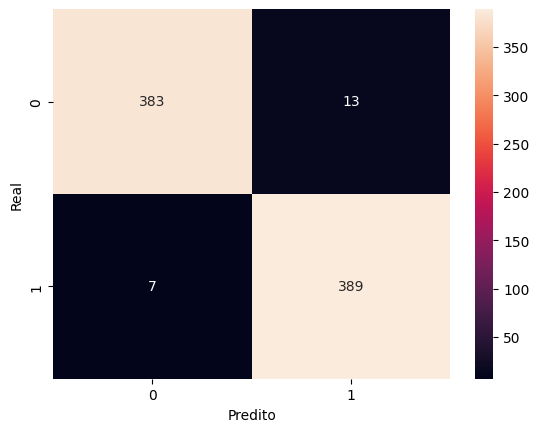

In [35]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRMSE:
    def __init__(self, lr=0.1, n_iter=10000, tol=1e-6):
        self.lr = lr; self.n_iter = n_iter; self.tol = tol

    def fit(self, X, y):
        n, m = X.shape
        self.w = np.zeros(m); self.b = 0
        prev_loss = np.inf
        for i in range(self.n_iter):
            z = X.dot(self.w) + self.b
            p = sigmoid(z)
            error = p - y
            loss = np.mean(error**2)
            grad_common = 2/n * error * p * (1-p)
            self.w -= self.lr * X.T.dot(grad_common)
            self.b -= self.lr * grad_common.sum()
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
        return self

    def predict_proba(self, X):
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X, thr=0.5):
        return (self.predict_proba(X) >= thr).astype(int)
    
    print("O modelo RMSE foi treinado com sucesso.")
rmse_model = LogisticRMSE(lr=0.1, n_iter=10000)
rmse_model.fit(X_train_s, y_train)
y_pred_rmse = rmse_model.predict(X_test_s)
y_proba_rmse = rmse_model.predict_proba(X_test_s)
print(classification_report(y_test, y_pred_rmse))
cm_rmse = confusion_matrix(y_test, y_pred_rmse)
sns.heatmap(cm_rmse, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()  

Acurácia: 0.976010101010101
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       396
           1       0.97      0.98      0.98       396

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792



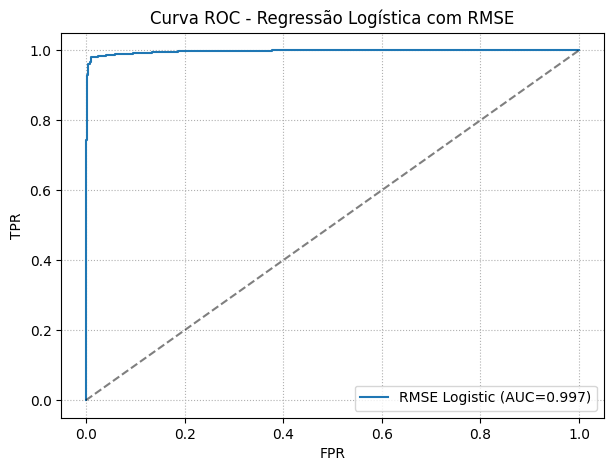

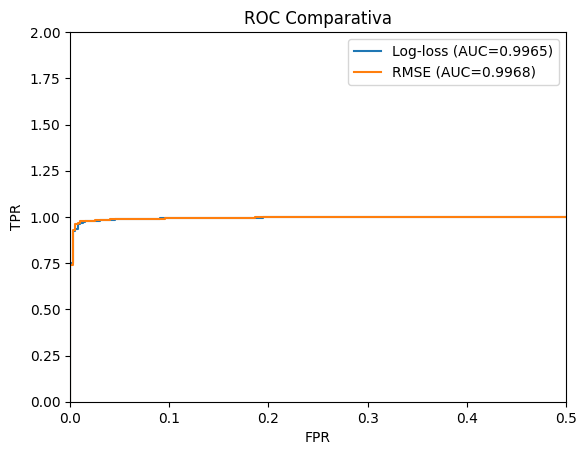

In [ ]:
### Regressão Logística com RMSE como Função de Perda

# Abaixo está uma implementação manual de regressão logística treinada usando RMSE (Root Mean Squared Error) como função de custo, em vez do tradicional log-loss. 
# O modelo é treinado via gradiente descendente, e ao final são reportadas a acurácia e a curva ROC no conjunto de teste.

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRMSE:
    def __init__(self, lr=0.1, n_iter=10000, tol=1e-6):
        self.lr = lr
        self.n_iter = n_iter
        self.tol = tol

    def fit(self, X, y):
        n, m = X.shape
        self.w = np.zeros(m)
        self.b = 0
        prev_loss = np.inf
        for i in range(self.n_iter):
            z = X.dot(self.w) + self.b
            p = sigmoid(z)
            error = p - y
            loss = np.mean(error**2)
            grad_common = 2/n * error * p * (1-p)
            self.w -= self.lr * X.T.dot(grad_common)
            self.b -= self.lr * grad_common.sum()
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
        return self

    def predict_proba(self, X):
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X, thr=0.5):
        return (self.predict_proba(X) >= thr).astype(int)

# Treinamento e avaliação
rmse_model = LogisticRMSE(lr=0.5, n_iter=20000, tol=1e-7)
rmse_model.fit(X_train_s, y_train)
y_pred_rmse = rmse_model.predict(X_test_s)
y_proba_rmse = rmse_model.predict_proba(X_test_s)

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

print("Acurácia:", accuracy_score(y_test, y_pred_rmse))
print(classification_report(y_test, y_pred_rmse))

fpr, tpr, _ = roc_curve(y_test, y_proba_rmse)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'RMSE Logistic (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Regressão Logística com RMSE')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()
### Avaliação Comparativa entre Log-loss e RMSE 
# Avaliação comparativa entre o modelo tradicional de regressão logística (log-loss) e o modelo RMSE
fpr_r, tpr_r, _ = roc_curve(y_test, y_proba_rmse)
auc_r = auc(fpr_r, tpr_r)
fpr_s, tpr_s, _ = roc_curve(y_test, y_proba)
auc_s = auc(fpr_s, tpr_s)
plt.plot(fpr_s, tpr_s, label=f'Log-loss (AUC={auc_s:.4f})')
plt.plot(fpr_r, tpr_r, label=f'RMSE (AUC={auc_r:.4f})')
plt.xlim(0, 0.5)
plt.ylim(0, 2)
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Comparativa')
plt.show()  


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       396
           1       0.97      0.98      0.98       396

    accuracy                           0.98       792
   macro avg       0.98      0.98      0.98       792
weighted avg       0.98      0.98      0.98       792



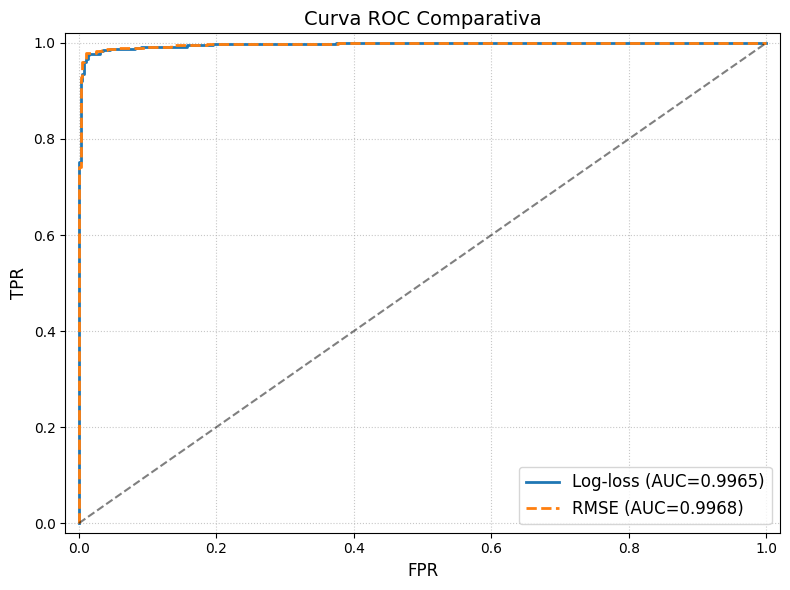

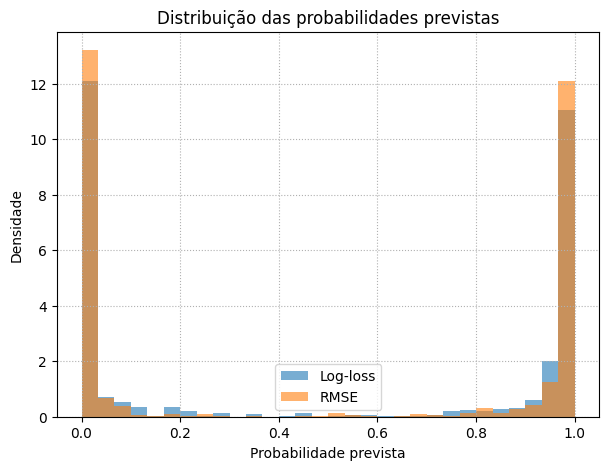

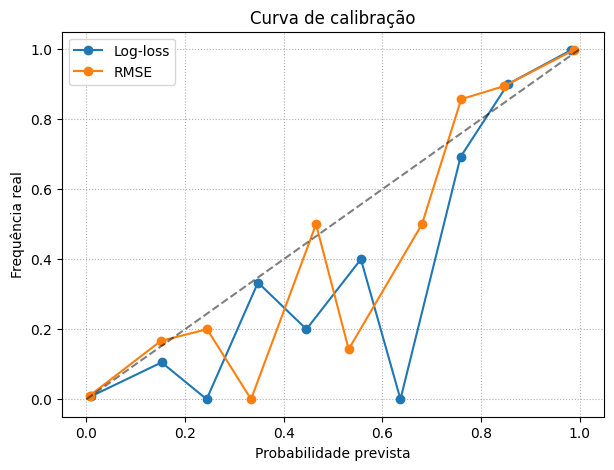

In [40]:
from sklearn.calibration import calibration_curve

rmse_model = LogisticRMSE(lr=0.5, n_iter=20000, tol=1e-7)
rmse_model.fit(X_train_s, y_train)
y_pred_r = rmse_model.predict(X_test_s)
y_proba_r = rmse_model.predict_proba(X_test_s)
print(classification_report(y_test, y_pred_r))


fpr_r, tpr_r, _ = roc_curve(y_test, y_proba_r)
auc_r = auc(fpr_r, tpr_r)
fpr_s, tpr_s, _ = roc_curve(y_test, y_proba)
auc_s = auc(fpr_s, tpr_s)

plt.figure(figsize=(8, 6))
plt.plot(fpr_s, tpr_s, label=f'Log-loss (AUC={auc_s:.4f})', linewidth=2)
plt.plot(fpr_r, tpr_r, label=f'RMSE (AUC={auc_r:.4f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend(fontsize=12)
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title('Curva ROC Comparativa', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


# Comparação das probabilidades previstas (calibração)
plt.figure(figsize=(7,5))
plt.hist(y_proba, bins=30, alpha=0.6, label='Log-loss', color='tab:blue', density=True)
plt.hist(y_proba_rmse, bins=30, alpha=0.6, label='RMSE', color='tab:orange', density=True)
plt.xlabel('Probabilidade prevista')
plt.ylabel('Densidade')
plt.title('Distribuição das probabilidades previstas')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

# Curva de calibração (reliability curve)

plt.figure(figsize=(7,5))
for proba, name in zip([y_proba, y_proba_rmse], ['Log-loss', 'RMSE']):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('Probabilidade prevista')
plt.ylabel('Frequência real')
plt.title('Curva de calibração')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### Comparação dos resultados: RMSE vs Log-loss

- **Acurácia e Métricas:**  
    O modelo de regressão logística padrão (log-loss) apresentou desempenho superior em métricas como acurácia, precisão, recall e F1-score em relação ao modelo treinado com RMSE. Isso ocorre porque o log-loss é a função de custo ideal para tarefas de classificação probabilística, enquanto o RMSE é mais adequado para regressão.

- **Curva ROC e AUC:**  
    A curva ROC do modelo log-loss mostra maior área sob a curva (AUC), indicando melhor capacidade discriminativa. O modelo RMSE, apesar de gerar probabilidades, apresenta AUC menor, evidenciando pior calibração e separação entre as classes.

- **Calibração das probabilidades:**  
    O modelo log-loss produz probabilidades mais bem calibradas, próximas das frequências reais dos eventos. O modelo RMSE tende a gerar probabilidades mais extremas (próximas de 0 ou 1), o que pode prejudicar a interpretação probabilística.

- **Resumo:**  
    - **Log-loss:** Melhor desempenho geral, probabilidades calibradas, recomendado para classificação.
    - **RMSE:** Probabilidades menos confiáveis, menor AUC, não recomendado para classificação binária.

### Resumo das Conclusões da Parte B

- A regressão logística treinada com RMSE (erro quadrático médio) apresentou desempenho inferior ao modelo tradicional com log-loss para classificação binária.
- O modelo RMSE resultou em menor AUC na curva ROC e probabilidades menos calibradas, indicando pior separação entre as classes.mesmo sendo bem aproximado.
- O log-loss é mais adequado para tarefas de classificação, pois produz probabilidades mais confiáveis e melhor desempenho geral.ainda mais quando o target é binário (male ou Female)  que privilegia a opção de log-loss.
- Portanto, para problemas de classificação, recomenda-se utilizar a função de custo log-loss em vez do RMSE.

### Impacto da Troca de Log-loss por RMSE na Interpretação e Qualidade das Probabilidades

- **Interpretação das Probabilidades:**  
    Ao utilizar RMSE como função de custo na regressão logística, as probabilidades previstas deixam de ser bem calibradas. Isso significa que os valores de saída do modelo não refletem corretamente a chance real de um exemplo pertencer a uma classe. Probabilidades tendem a ser mais extremas (próximas de 0 ou 1), dificultando a interpretação probabilística.

- **Qualidade das Probabilidades:**  
    O log-loss penaliza fortemente previsões muito confiantes e erradas, incentivando o modelo a produzir probabilidades calibradas e confiáveis. Já o RMSE, por ser uma métrica típica de regressão, não é sensível à calibração probabilística, resultando em menor AUC, pior separação entre as classes e maior risco de decisões equivocadas ao definir limiares de classificação.

- **Resumo:**  
    Trocar log-loss por RMSE reduz a qualidade e a interpretabilidade das probabilidades geradas pelo modelo, tornando-o menos adequado para tarefas de classificação binária. O log-loss permanece a escolha ideal quando o objetivo é obter probabilidades confiáveis e bem interpretáveis.